# Classifying web-scraped burn images with fastai
## Constantin Baumgartner

This was an experimental exercise to get an understanding of the in's and out's of clasifying web-scraped first, second, and third degree burn images using deep learning. Specifically, I tried to answer the following questions:

- What parameters are best suited for classifying burn images (input image size, image transforms and augmentations, etc.)

- Which CNN model architecture performs best (ResNet, DenseNet, VGG)

- How do different model architectures perform across the different classes

- Does un-freezing the network improve training, or are the pre-trained weights sufficient to perform accurately classify the burns?

I analyzed the performance of the following models (only the results from the best model from each architecture category are presented in this notebook):

- VGG
    - VGG16 with batchnorm
    - VGG19 with batchnorm
- ResNet
    - ResNet34
    - ResNet50
    - ResNet101
    - ResNet152
- DenseNet
    - DenseNet121
    - DenseNet161
    - DenseNet201

I preempt this notebook with the following disclaimer:

**All images were labeled without medical training using the resources and information readily available on the web.**


## Results

- An input size of 224x224 is ideal. Smaller input sizes result in less accurate models, but higher input sizes result in deminishing returns due to the increased training time and limited image resolution of the web scraped images. A model trained on medical-grade images may benefit from larger images.


- The standard fastai image transforms are hard to beat with the acception of adding vertical-flipping due to the top-down nature of medical images.

- Initally, the imbalance of certain body parts between the classes resulted in the model learning body features rather than burn characteristics. The first degree class contains many sunburn images (faces and shoulders) and the second degree class contains many images of hands and arms (common locations for second degree burns). Most images containing hands were classified as second degree burns regardless of the actual burn severity.


- Adding images of un-burnt body parts (hands, feet, arms, legs, torsos, backs, and heads) as a fourth class, 'none', had a regularization effect on the model. This improved the models ability to distinguish between different types of burns and resulted in significant accuracy increases across all model architectures and input sizes.


- Prior to adding the 'none' class, unfreezing the layers had no statistically significant effect on model accuracy. Once the 'none' class was added the model accuracy improved when unfreezing across all architectures. This makes sense conceptually. We assume that unfreezing earlier layers allowed the weights of the earlier layers to adjust so that they're more sensitive to burn characteristics and less sensitive to body features. This only works if the model sees examples of the same body part with and without burns.


- Test Time Augmentation (TTA) results in much more consistent predictions and leads to better generalizability. TTA will be a vital part of any computer vision system used to diagnose burn depth.


- ResNet151 performs best with a validation accuracy of **88.6%**.


- The highest misclassification rates were between first and third degree burns. This is weird. I would expect 2nd degree burns to be a natural bridge between first and third degree burns. This may be due to an underlying problem in the data distribution, i.e. second degree burns have a high presence of blisters thus making them easier to identify.


- From the heatmaps it looks like both the ResNet and DenseNet architectures do a better job of localizing the burn area, although a more detailed, quantitative analysis is required to draw this conclusion with certainty.
    

## Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from utility import plot_confusion_matrix

In [3]:
PATH = Path('/home/constantin.baumgartner/data/burn_data_v10/')
sz = 224
bs = 16

In [11]:
tfms = get_transforms(flip_vert = True)

In [12]:
data = (ImageList.from_folder(PATH)
          .split_by_rand_pct(valid_pct = 0.3)
          .label_from_folder()
          .transform(tfms = tfms, size = sz)
          .databunch(bs = bs)
          .normalize(imagenet_stats))

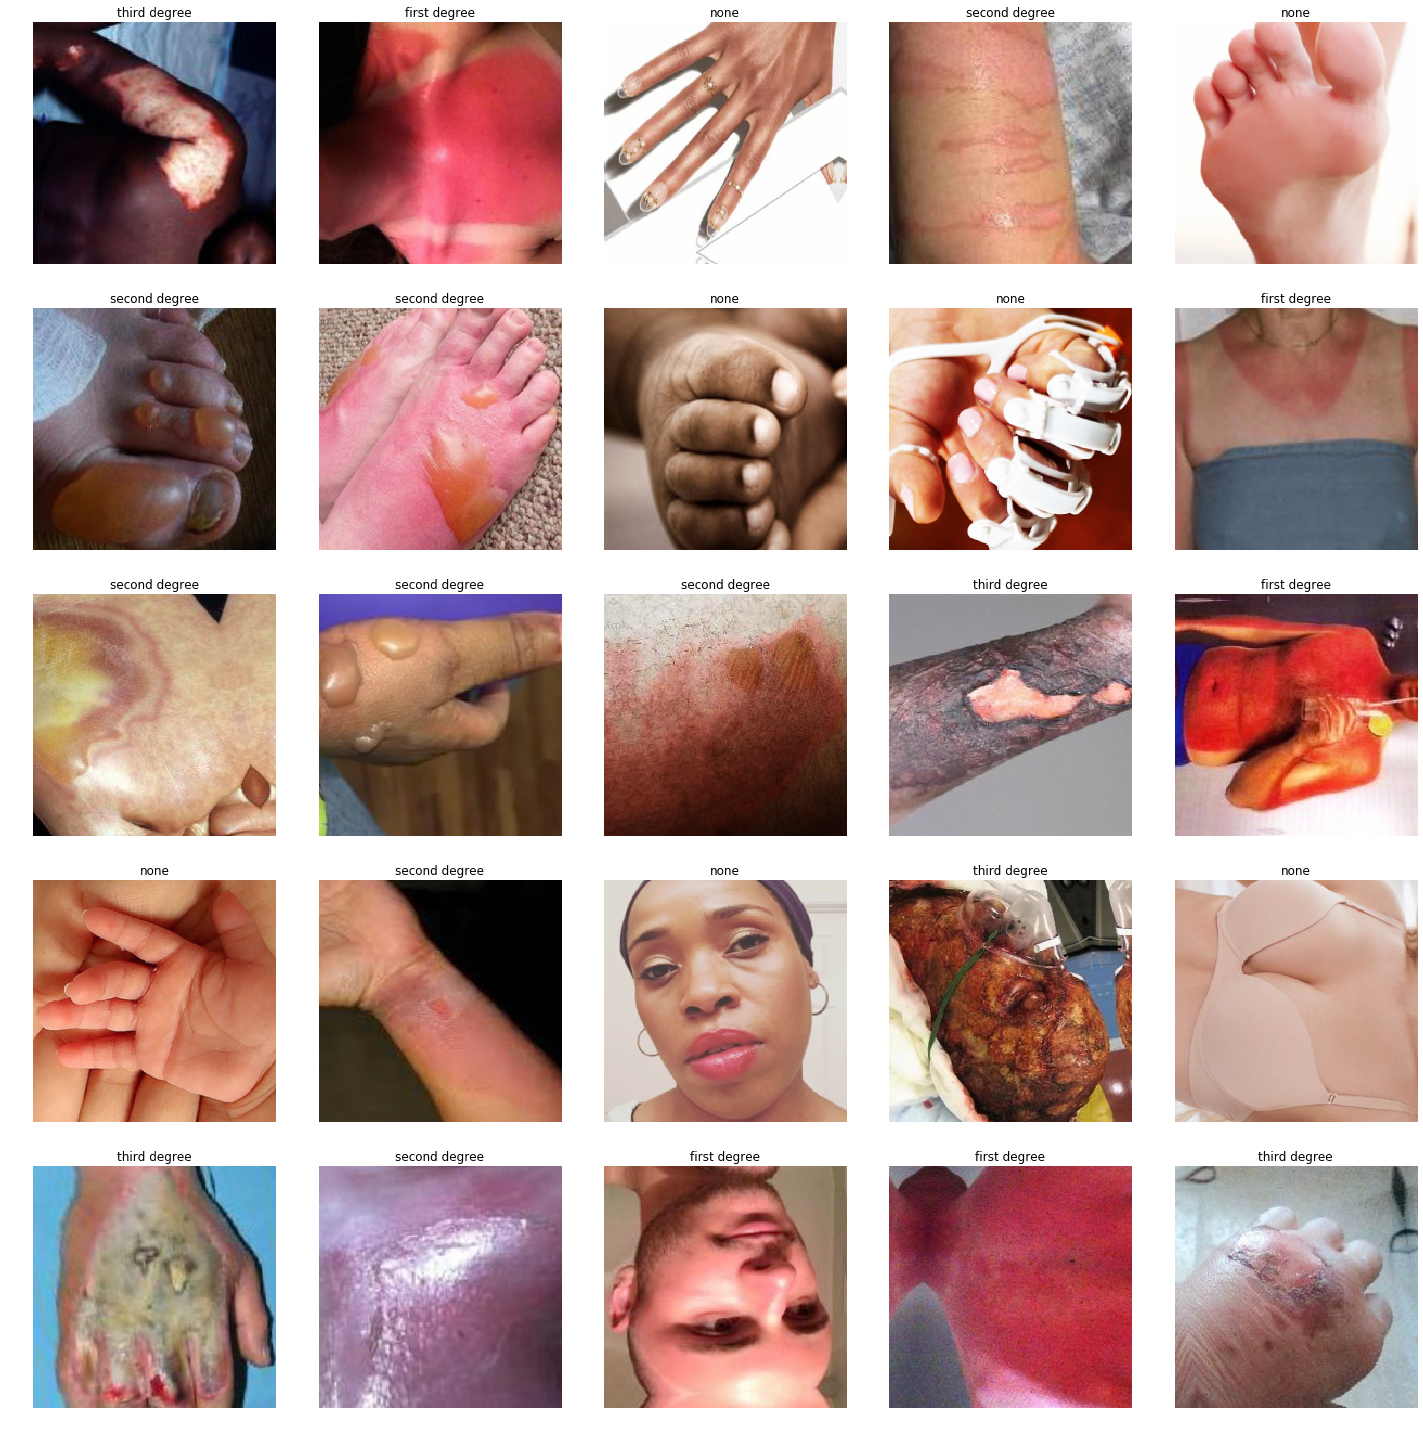

In [6]:
data.show_batch(rows = 5)

## Model & Training

### VGG19 with batchnorm

#### Frozen (only head is heing trained)

In [105]:
learn = cnn_learner(data, models.vgg19_bn, metrics = accuracy)

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


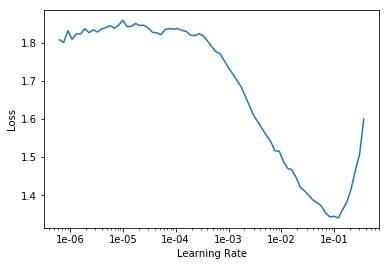

In [55]:
learn.recorder.plot(suggested=True)

In [66]:
learn.fit_one_cycle(3, 2e-3)

In [67]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [68]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.789


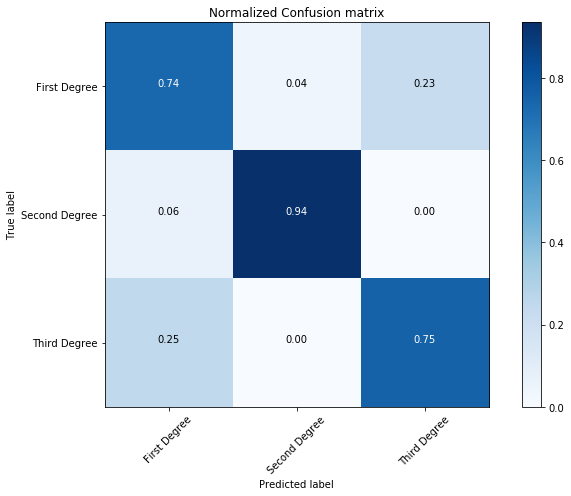

In [69]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

In [70]:
learn.save('vgg19bn_frozen_webdata')

#### Unfrozen (entire model is being trained)

In [71]:
learn.unfreeze()

In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


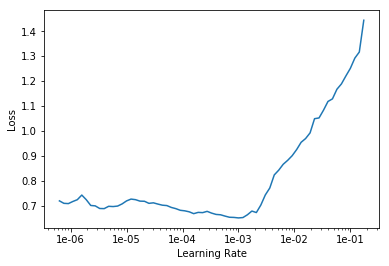

In [73]:
learn.recorder.plot(suggested=True)

In [74]:
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

In [107]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [76]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.786


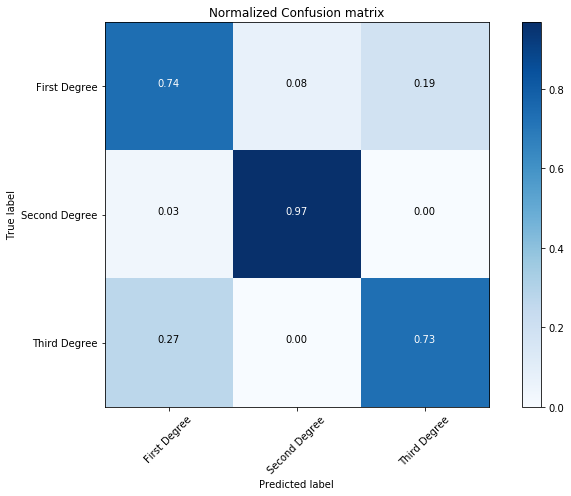

In [77]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

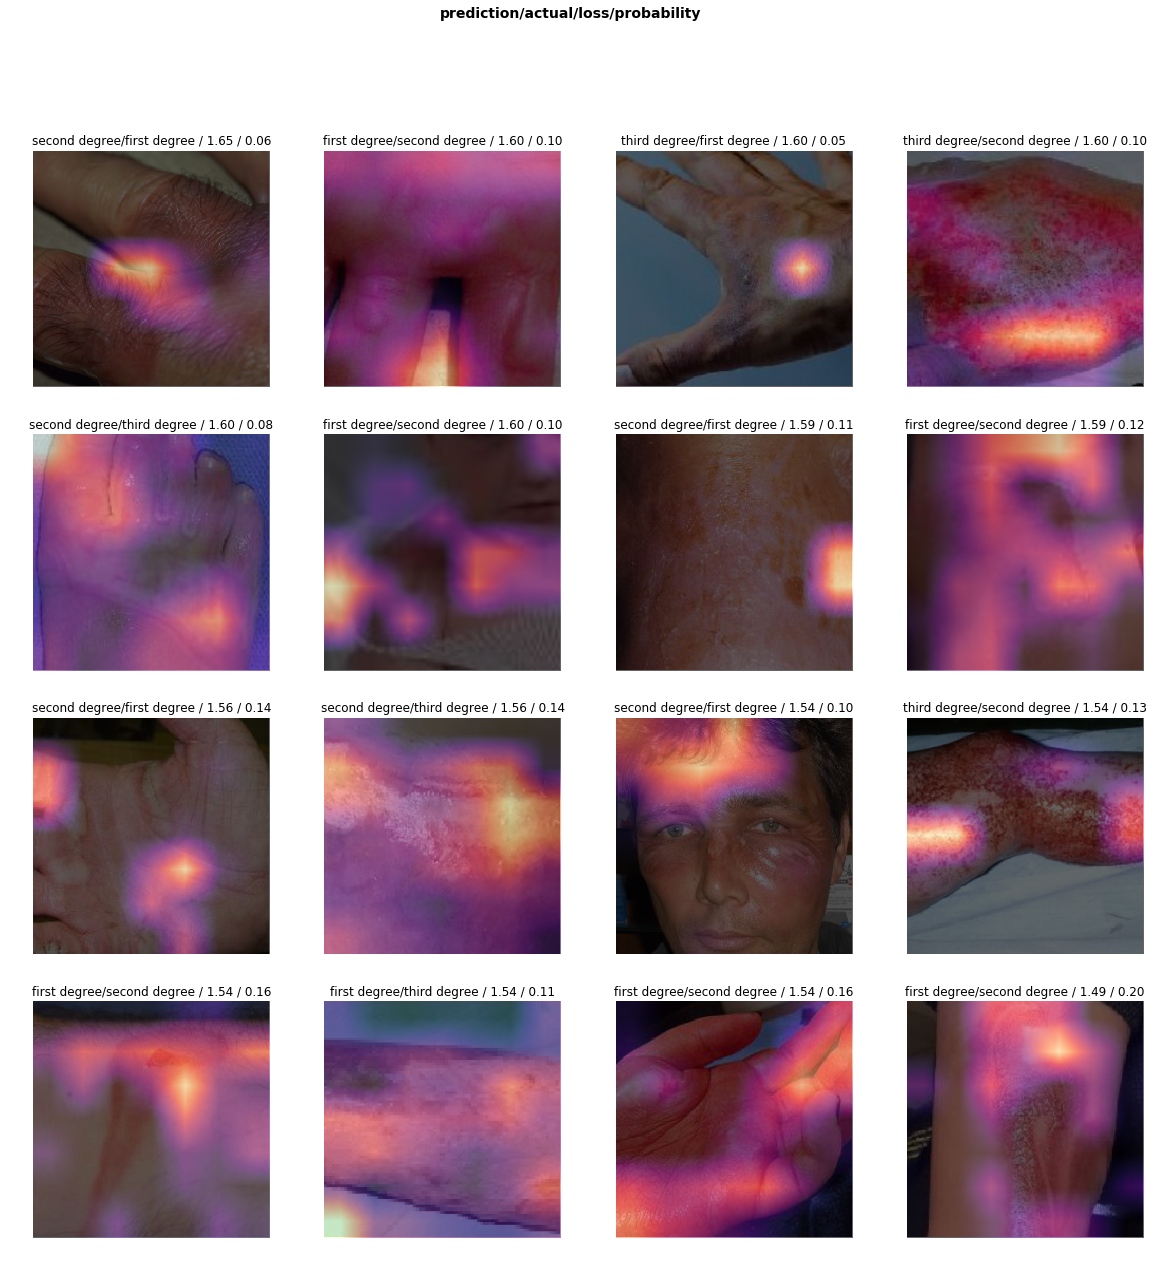

In [109]:
interp.plot_top_losses(16, figsize=(20,20))

In [78]:
learn.save('vgg19bn_unfrozen_webdata')

### DensNet 201

#### Frozen (only head is being trained)

In [29]:
learn = cnn_learner(data, models.densenet201, metrics = accuracy)

/home/constantin.baumgartner/.conda/envs/fellowship_env/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


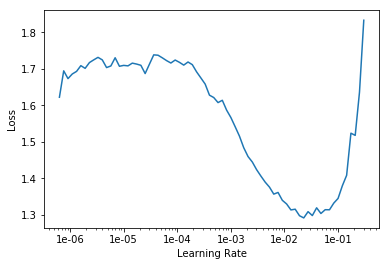

In [31]:
learn.recorder.plot(suggested=True)

In [32]:
learn.fit_one_cycle(10, 3e-3)

In [33]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [34]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.854


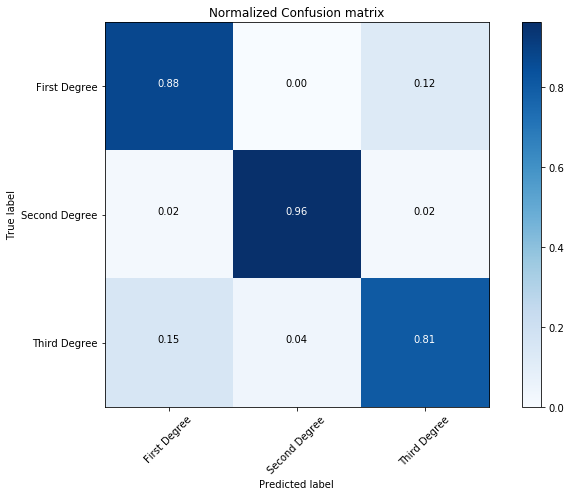

In [35]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

In [36]:
learn.save('densenet201_frozen_webdata')

#### Unfrozen (entire model is being trained)

In [37]:
learn.unfreeze()

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


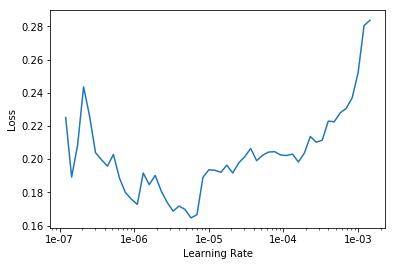

In [41]:
learn.recorder.plot(suggested=True, skip_start = 1, skip_end=7)

In [42]:
learn.fit_one_cycle(10, slice(3e-7, 1e-6))

In [43]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [44]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.864


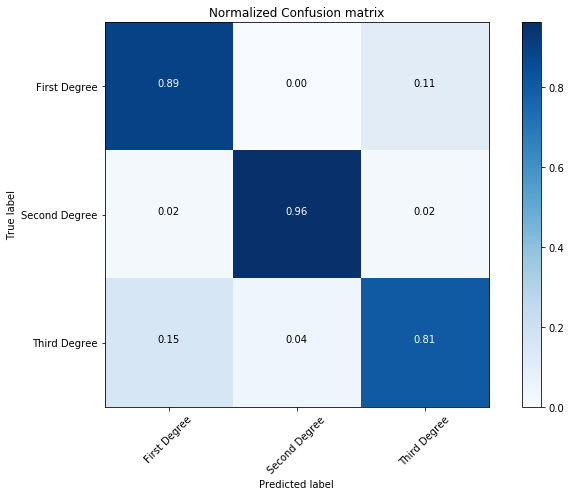

In [45]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

In [46]:
learn.save('densenet201_unfrozen_webdata')

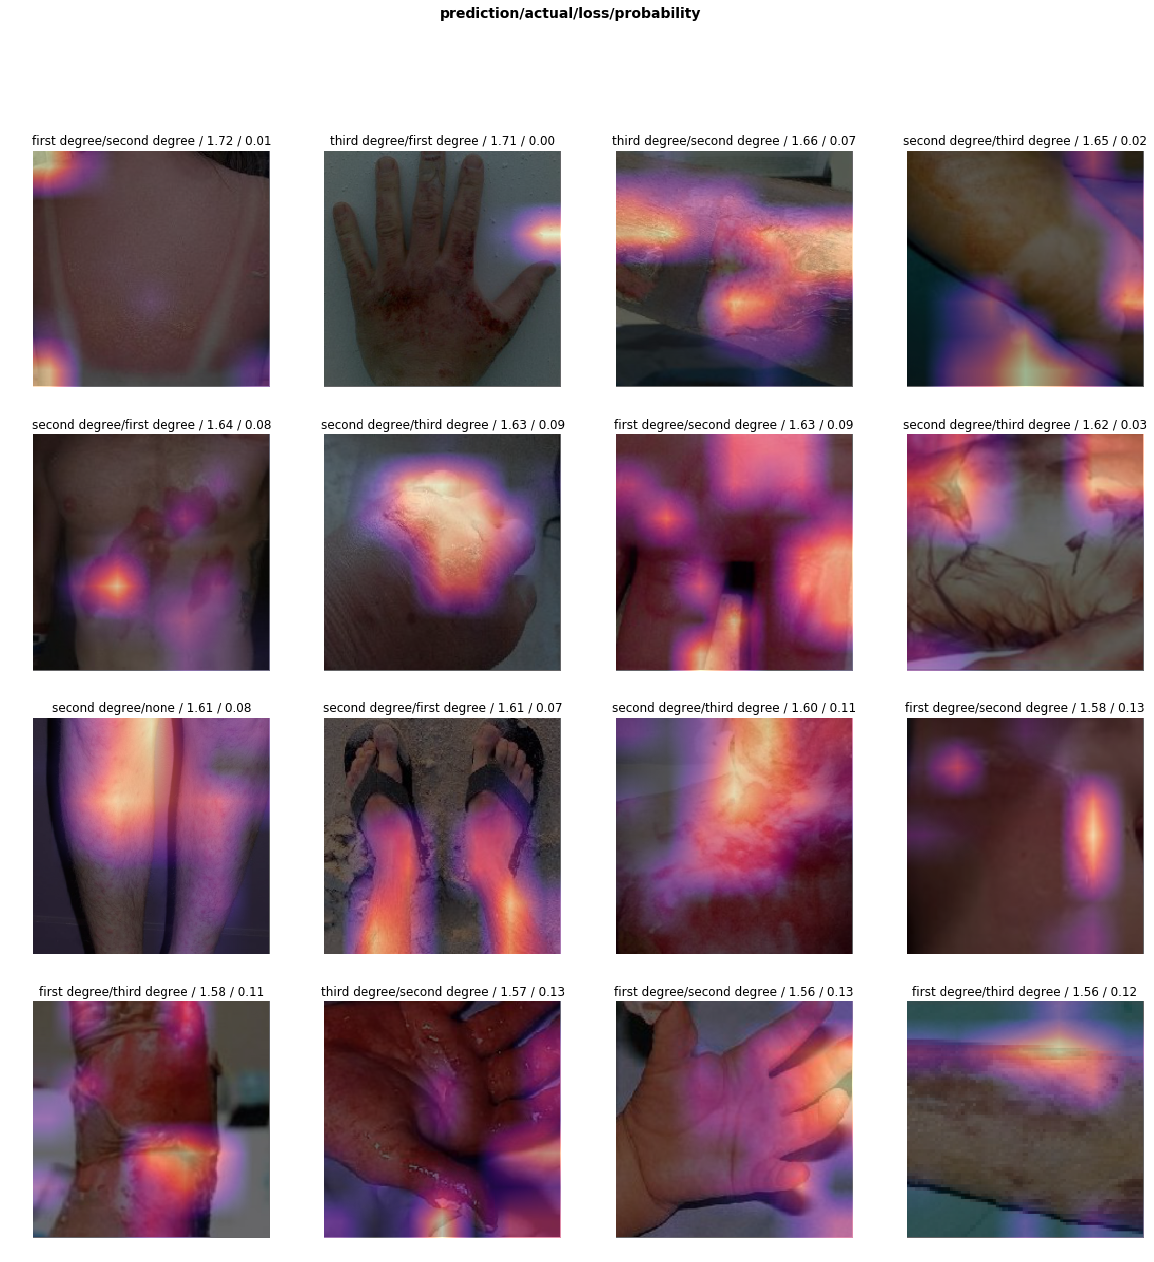

In [47]:
interp.plot_top_losses(16, figsize=(20,20))

### ResNet 152

#### Frozen (only head is being trained)

In [70]:
learn = cnn_learner(data, models.resnet152, metrics = accuracy)

In [71]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


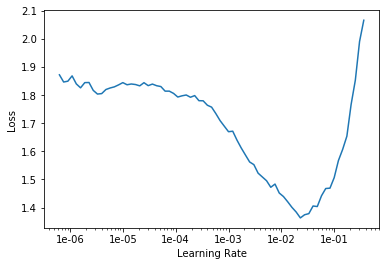

In [72]:
learn.recorder.plot(suggested=True)

In [73]:
learn.fit_one_cycle(10, 4e-3)

In [74]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [75]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.859


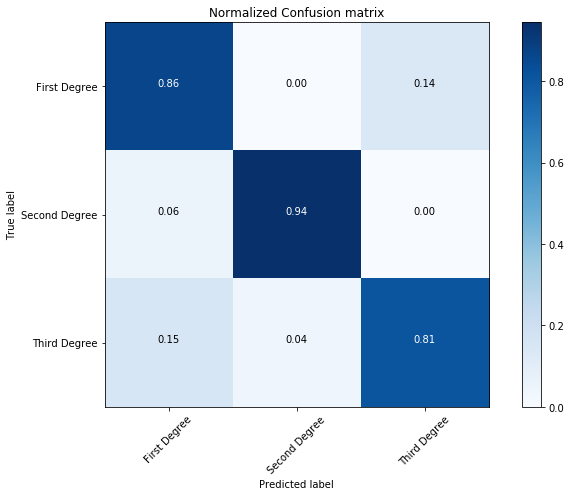

In [76]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

In [55]:
learn.save('resnet152_frozen_webdata')

#### Unfrozen (entire model is being trained)

In [77]:
learn.unfreeze()

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


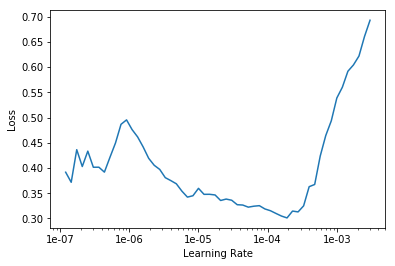

In [80]:
learn.recorder.plot(suggested=True, skip_start = 1, skip_end=20)

In [81]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5))

In [82]:
interp = ClassificationInterpretation.from_learner(learn, tta=True)
cm = interp.confusion_matrix()
# normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [83]:
# accuracy without 'none' class
no_none_acc = [cm[i,i] for i in range(3)]
no_none_acc = round(sum(no_none_acc)/3, 3)
print(f'Accuracy without none class: {no_none_acc}')

Accuracy without none class: 0.886


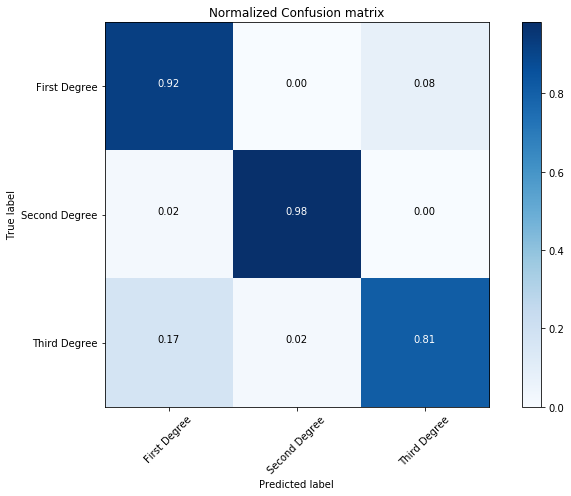

In [84]:
plot_confusion_matrix(cm[:3,:3], 
                      ['First Degree', 'Second Degree', 'Third Degree'], 
                      normalize = True,
                     figsize = (10,7))

In [85]:
learn.save('resnet152_unfrozen_webdata')

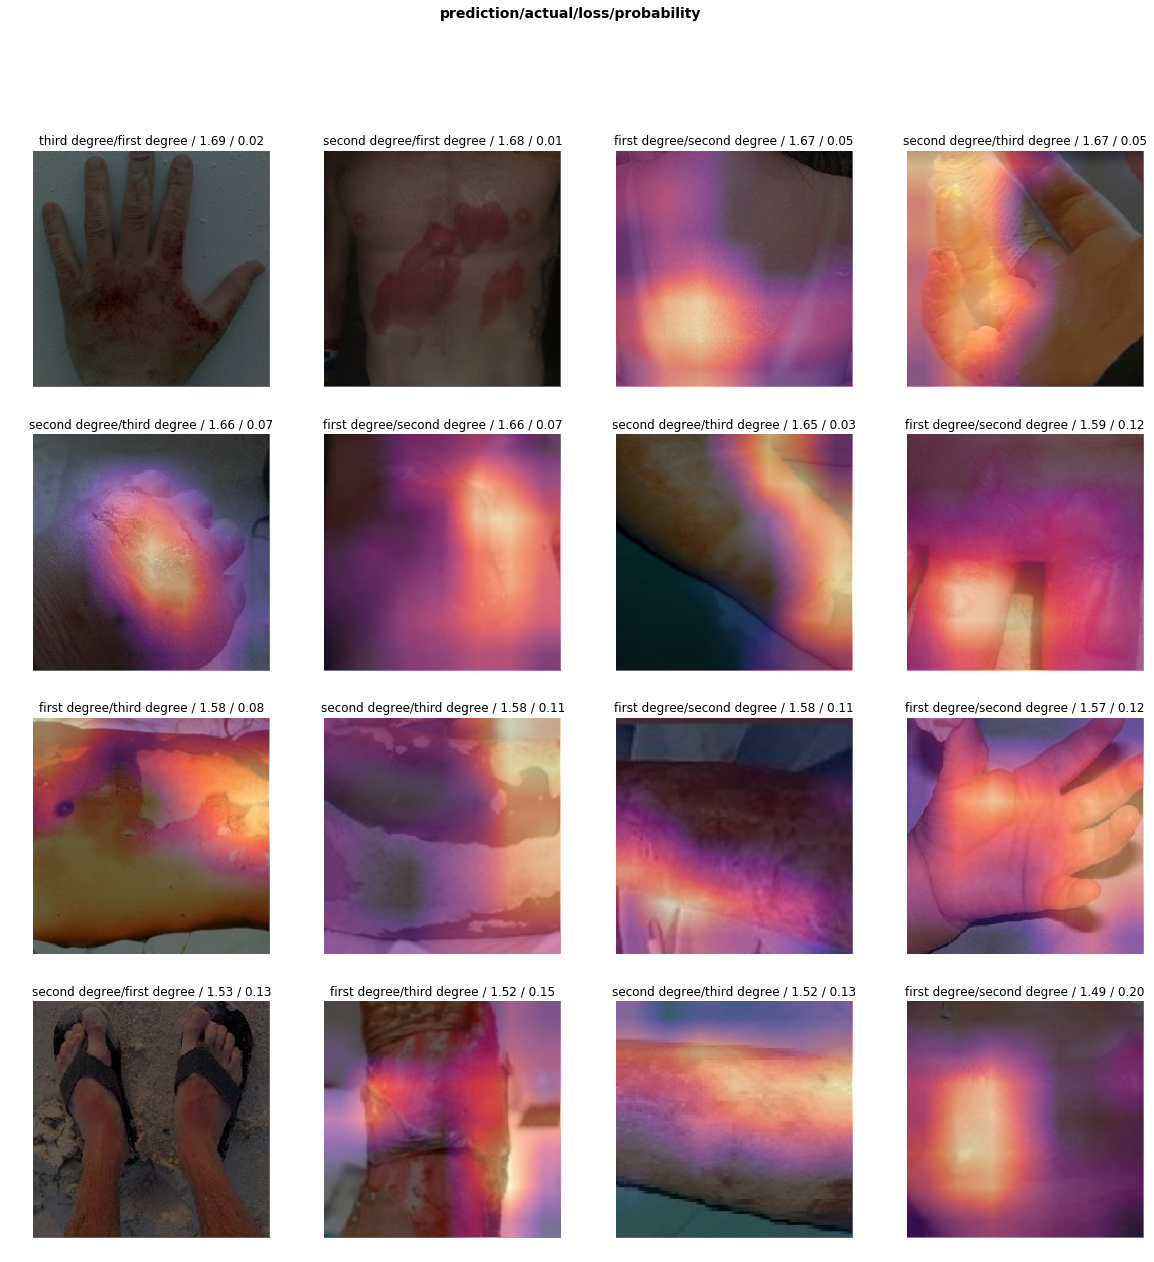

In [86]:
interp.plot_top_losses(16, figsize=(20,20))